## Time Series: Climate Data
![climate](https://images.pexels.com/photos/2969/climate-cold-glacier-iceberg.jpg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)
**Objectives:**
- list methods to adjust data for time series
- define the vocabulary of lagging, moving averages, and differencing
- replicate the process in google sheets and in python

**Question**: What are numbers we'd want to model over time?

**Problem:** All our tools aren't natively prepared to handle time series data. We need to make a lot of adjustments to our data. 

### Set up environment and tool set 

In [42]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [43]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)

3.1.0
0.24.2
1.16.4
0.10.0
1.3.0


Data obtained from `https://datahub.io/core/global-temp#data`<br>
Looks like original source is obtained from `https://www.ncdc.noaa.gov/cag/global/time-series`

Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG)

### Obtain and visualize data

In [44]:
## data obtained from https://datahub.io/core/global-temp#data
df = pd.read_csv("https://pkgstore.datahub.io/core/global-temp/annual_csv/data/a26b154688b061cdd04f1df36e4408be/annual_csv.csv")
df.head()

,Source,Year,Mean
0,GCAG,2016,0.9363
1,GISTEMP,2016,0.9900
2,GCAG,2015,0.8998
3,GISTEMP,2015,0.8700
4,GCAG,2014,0.7408


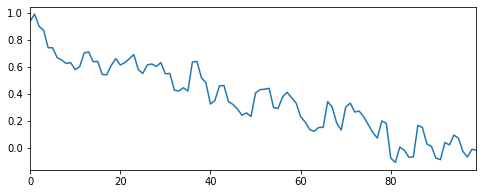

In [45]:
df.Mean[:100].plot()

### Exercise: what is wrong with the data and plot above? How can we fix this?

In [46]:
df = df.pivot(index='Year', columns='Source', values='Mean')

In [47]:
df.head()

Source,GCAG,GISTEMP
Year,,
1880,-0.1148,-0.20
1881,-0.0628,-0.12
1882,-0.0648,-0.10
1883,-0.1424,-0.21
1884,-0.2009,-0.28


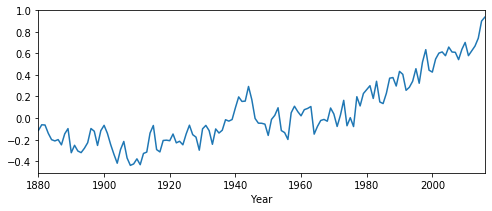

In [48]:
df.GCAG.plot()

In [49]:
type(df.index)

pandas.core.indexes.numeric.Int64Index

### Exercise: how can we make the index more time aware?

In [50]:
df.index = pd.to_datetime(df.index, format='%Y')

In [51]:
df.head()

Source,GCAG,GISTEMP
Year,,
1880-01-01,-0.1148,-0.20
1881-01-01,-0.0628,-0.12
1882-01-01,-0.0648,-0.10
1883-01-01,-0.1424,-0.21
1884-01-01,-0.2009,-0.28


In [52]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

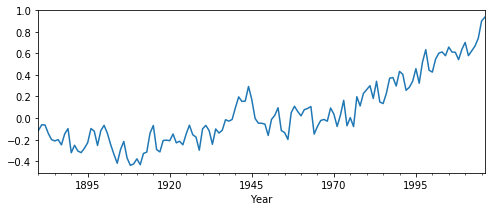

In [53]:
df.GCAG.plot()

In [54]:
df['1880']

Source,GCAG,GISTEMP
Year,,
1880-01-01,-0.1148,-0.2


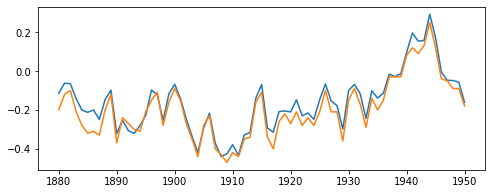

In [55]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])

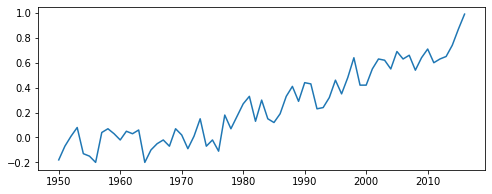

In [56]:
plt.plot(df['1950':][['GISTEMP']])

## Logging

`np.log()`

In [59]:
df['GISTEMP_log'] = np.log(df.GISTEMP)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [60]:
# df['GCAG_log'] = np.log(df.GCAG)
df.tail(10)

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log
Year,,,,
2007-01-01,0.6100,0.66,-0.494296,-0.415515
2008-01-01,0.5419,0.54,-0.612674,-0.616186
2009-01-01,0.6367,0.64,-0.451457,-0.446287
2010-01-01,0.7014,0.71,-0.354677,-0.342490
2011-01-01,0.5788,0.60,-0.546798,-0.510826
2012-01-01,0.6240,0.63,-0.471605,-0.462035
2013-01-01,0.6679,0.65,-0.403617,-0.430783
2014-01-01,0.7408,0.74,-0.300025,-0.301105
2015-01-01,0.8998,0.87,-0.105583,-0.139262


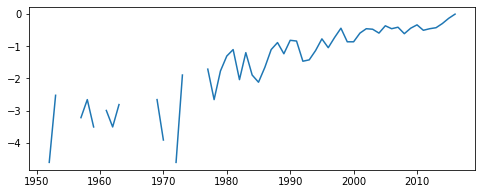

In [61]:
plt.plot(df['1950':][['GISTEMP_log']])

## Lagging

`shift()` [shift documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)

In [62]:
df['GCAG_lag1'] = df.GCAG.shift()

In [63]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1
Year,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424


In [64]:
df['GISTEMP_lag1'] = df.GISTEMP.shift()
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GISTEMP_lag1
Year,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,-0.20
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.12
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.10
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.21



## Differencing

`diff()` [diff documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html)

#### First order difference

In [65]:
df['GCAG_diff1']=df.GCAG.diff()

In [67]:
df['GISTEMP_diff1'] = df.GISTEMP.diff()

In [68]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GISTEMP_lag1,GCAG_diff1,GISTEMP_diff1
Year,,,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,-0.20,0.0520,0.08
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.12,-0.0020,0.02
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.10,-0.0776,-0.11
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.21,-0.0585,-0.07


#### Second order difference

In [69]:
df['GCAG_diff2']=df.GCAG_diff1.diff()

In [71]:
df['GISTEMP_diff2'] = df.GISTEMP_diff1.diff()

In [72]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GISTEMP_lag1,GCAG_diff1,GISTEMP_diff1,GCAG_diff2,GISTEMP_diff2
Year,,,,,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,-0.20,0.0520,0.08,NaN,NaN
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.12,-0.0020,0.02,-0.0540,-0.06
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.10,-0.0776,-0.11,-0.0756,-0.13
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.21,-0.0585,-0.07,0.0191,0.04


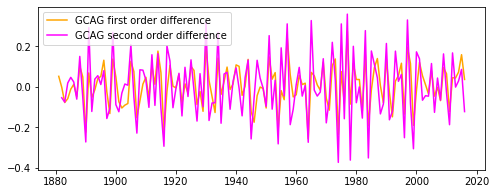

In [73]:
plt.plot(df.index, df.GCAG_diff1, label='GCAG first order difference', color='orange')
plt.plot(df.index, df.GCAG_diff2, label='GCAG second order difference', color='magenta')
plt.legend(loc='upper left')
plt.show()

## Moving Average

![img](img/MA.png)

`rolling()`  [rolling here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)

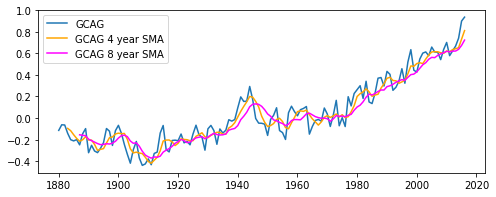

In [74]:
rolling_mean = df.GCAG.rolling(window=4).mean()
rolling_mean2 = df.GCAG.rolling(window=8).mean()
plt.plot(df.index, df.GCAG, label = 'GCAG')
plt.plot(df.index, rolling_mean, label='GCAG 4 year SMA', color='orange')
plt.plot(df.index, rolling_mean2, label='GCAG 8 year SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

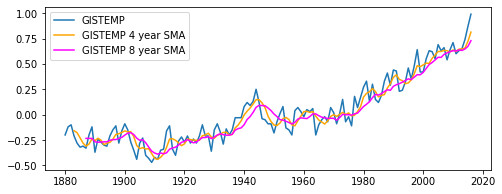

In [75]:
rolling_mean = df.GISTEMP.rolling(window=4).mean()
rolling_mean2 = df.GISTEMP.rolling(window=8).mean()
plt.plot(df.index, df.GISTEMP, label = 'GISTEMP')
plt.plot(df.index, rolling_mean, label='GISTEMP 4 year SMA', color='orange')
plt.plot(df.index, rolling_mean2, label='GISTEMP 8 year SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

### Exercise: How strongly do these measurements correlate contemporaneously? What about with a time lag?

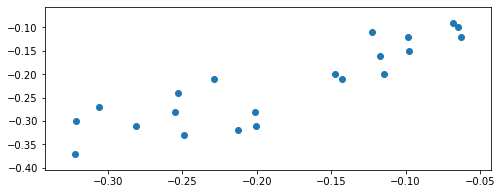

In [76]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])

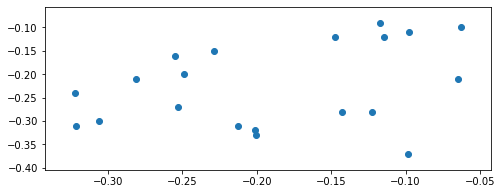

In [77]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])

In [ ]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

In [ ]:
df['1880':'1899'][['GCAG']].head()

In [ ]:
df['1881':'1900'][['GISTEMP']].head()

In [ ]:
min(df.index)

In [78]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GISTEMP_lag1,GCAG_diff1,GISTEMP_diff1,GCAG_diff2,GISTEMP_diff2
Year,,,,,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,-0.20,0.0520,0.08,NaN,NaN
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.12,-0.0020,0.02,-0.0540,-0.06
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.10,-0.0776,-0.11,-0.0756,-0.13
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.21,-0.0585,-0.07,0.0191,0.04


In [79]:
df['GCAG_lag2'] = df.GCAG.shift(2)

In [80]:
df['GCAG_lag3'] = df.GCAG.shift(3)

In [81]:
df['GCAG_lag4'] = df.GCAG.shift(4)

In [84]:
df[["GCAG", 'GCAG_lag1', 'GCAG_lag2', 'GCAG_lag3', 'GCAG_lag4']].corr()

Source,GCAG,GCAG_lag1,GCAG_lag2,GCAG_lag3,GCAG_lag4
Source,,,,,
GCAG,1.000000,0.946235,0.911005,0.898884,0.898513
GCAG_lag1,0.946235,1.000000,0.942859,0.907034,0.895385
GCAG_lag2,0.911005,0.942859,1.000000,0.940571,0.903916
GCAG_lag3,0.898884,0.907034,0.940571,1.000000,0.938279
GCAG_lag4,0.898513,0.895385,0.903916,0.938279,1.000000


In [ ]:
max(df.index)

### References:

- [Duke resource on differencing](https://people.duke.edu/~rnau/411diff.htm)
- [Scipy talk on time series](https://www.youtube.com/watch?v=v5ijNXvlC5A)
- [Aileen Nielson book](https://www.oreilly.com/library/view/practical-time-series/9781492041641/)

### Check Objectives


In [85]:
monthly = pd.read_csv("https://datahub.io/core/global-temp/r/monthly.csv")

In [86]:
monthly.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [87]:
monthly.dtypes

Source     object
Date       object
Mean      float64
dtype: object

In [89]:
dfm = monthly.pivot(index='Date', columns='Source', values='Mean')

In [90]:
dfm.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
